In [1]:
from pathlib import Path

import jupyter_black
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from hydra import compose
from hydra import initialize
from hydra.core.global_hydra import GlobalHydra

from src.utils.metrics import event_detection_ap
from src.utils.post_process import post_process_for_seg

jupyter_black.load()
# plt.style.use("ggplot")
sns.set()

%load_ext autoreload
%autoreload 2


def load_config(result_dir: Path):
    # clear previous initialization
    GlobalHydra.instance().clear()

    # initialize hydra
    config_path = result_dir / ".hydra"
    initialize(config_path=config_path.as_posix())
    # load the config
    cfg = compose(config_name="config")

    return cfg

In [2]:
EXP_NAME = "exp125"
RUN_NAMES = ["run0", "run1", "run2", "run3", "run4"]
all_preds = []
all_keys = []
all_labels = []
for run_name in RUN_NAMES:
    RESULT_DIR = Path("../output/train") / EXP_NAME / run_name
    cfg = load_config(RESULT_DIR)
    preds = np.load(RESULT_DIR / "preds.npy")
    labels = np.load(RESULT_DIR / "labels.npy")
    keys = np.load(RESULT_DIR / "keys.npy")
    all_preds.append(preds)
    all_keys.append(keys)
    all_labels.append(labels)

all_preds = np.concatenate(all_preds)
all_keys = np.concatenate(all_keys)
all_labels = np.concatenate(all_labels)
gt_df = pd.read_csv(Path(cfg.dir.data_dir) / "train_events.csv").dropna().reset_index(drop=True)

/tmp/ipykernel_2060142/122198152.py:32: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())
/tmp/ipykernel_2060142/122198152.py:32: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())


Text(0, 0.5, 'discount rate')

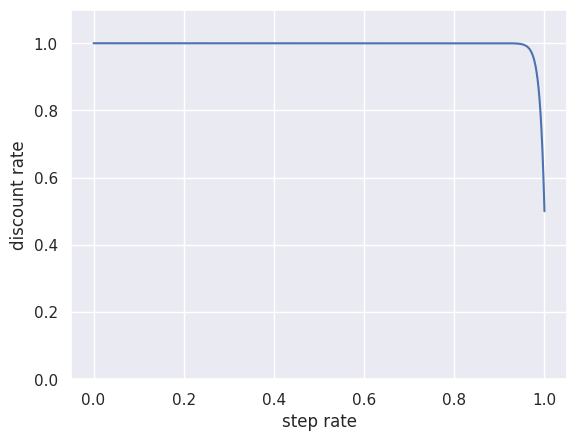

In [3]:
max_steps = 1000000
step_rate = np.arange(0, max_steps) / max_steps
k = 0.5
discount_rate = 1 - (1 - k) * step_rate**100
plt.plot(step_rate, discount_rate)
plt.ylim(0, 1.1)
plt.xlabel("step rate")
plt.ylabel("discount rate")

In [4]:
cfg.post_process.score_th = 0.001
cfg.post_process.distance = 70
cfg.post_process.low_pass_filter_hour = 5

In [22]:
for score_k in [0.0, 0.2, 0.4, 0.6]:
    pred_df1: pl.DataFrame = post_process_for_seg(
        all_keys,
        all_preds[:, :, [1, 2]],
        score_th=cfg.post_process.score_th,
        distance=cfg.post_process.distance,
        low_pass_filter_hour=cfg.post_process.low_pass_filter_hour,
        score_decay_k=score_k,
        score_decay_m=100,
    )
    score1 = event_detection_ap(
        gt_df.query(f'series_id in {pred_df1["series_id"].unique().to_list()}'),
        pred_df1.to_pandas(),
    )
    print(f"score_k:{score_k} score1:{score1:.5f}")

score_k:0.0 score1:0.78763
score_k:0.2 score1:0.78754
score_k:0.4 score1:0.78744
score_k:0.6 score1:0.78726


## 改善したいケース例

In [5]:
def plot_random_sample(keys, preds, labels, unique_series_ids, num_chunks=10):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    for i, random_series_id in enumerate(unique_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)

        # scoring
        pred = this_series_preds[:, [1, 2]]
        pred_df: pl.DataFrame = post_process_for_seg(
            [random_series_id] * len(pred),
            pred,
            score_th=0.001,
            distance=70,
            low_pass_filter_hour=5,
        )
        _gt_df = gt_df.query("series_id==@random_series_id")
        if len(_gt_df) == 0:
            score = 0.0
        else:
            score = event_detection_ap(_gt_df, pred_df.to_pandas())

        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 4 * num_chunks))
        if num_chunks == 1:
            axs = [axs]

        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            onset_idx = np.nonzero(this_series_labels_chunk[:, 1])[0]
            wakeup_idx = np.nonzero(this_series_labels_chunk[:, 2])[0]

            axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            axs[j].plot(this_series_preds_chunk[:, 1], label="pred_onset")
            axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
            axs[j].vlines(onset_idx, 0, 1, label="gt_onset", linestyles="dashed", color="C1")
            axs[j].vlines(wakeup_idx, 0, 1, label="gt_wakeup", linestyles="dashed", color="C2")
            axs[j].set_ylim(-0.1, 1.1)
            axs[j].set_title(
                f"i={i} series_id: {random_series_id} chunk_id: {j} score: {score:.4f}"
            )
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()

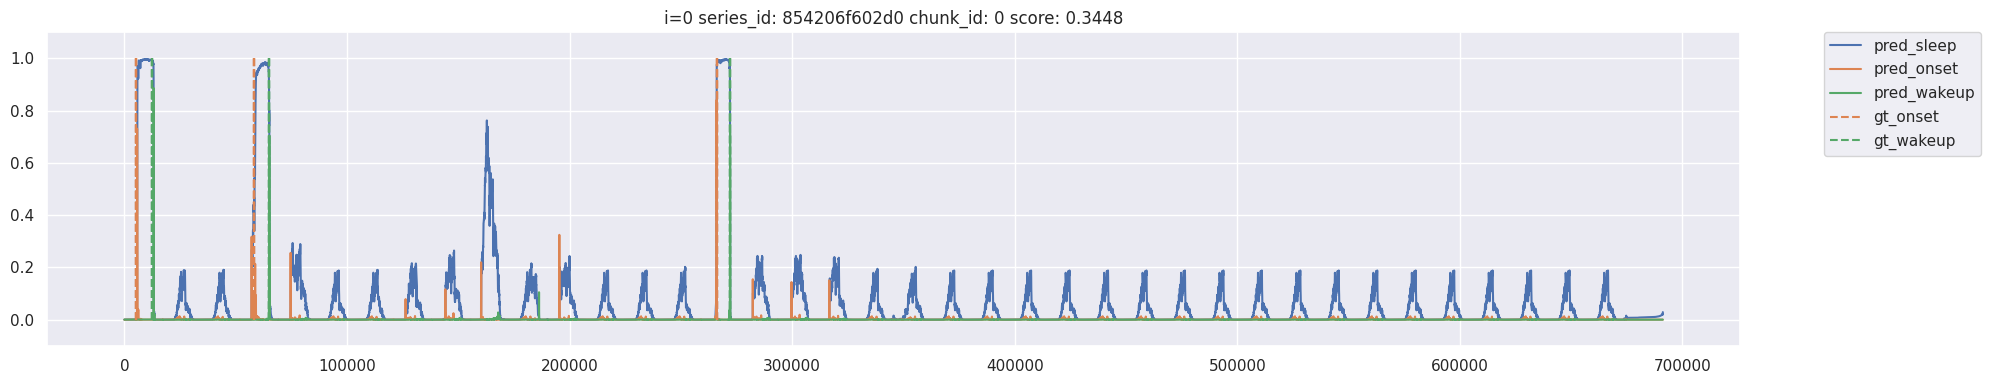

In [6]:
np.random.seed(0)
unique_series_ids = ["854206f602d0"]
plot_random_sample(all_keys, all_preds, all_labels, unique_series_ids, num_chunks=1)

In [7]:
def get_submission_df(
    preds, keys, labels, target_series_id, score_th=0.001, distance=70, low_pass_filter_hour=5
):
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    series_idx = np.where(series_ids == target_series_id)[0]
    this_series_preds = preds[series_idx].reshape(-1, 3)
    pred_df = post_process_for_seg(
        [target_series_id] * len(this_series_preds),
        this_series_preds[:, [1, 2]],
        score_th,
        distance,
        low_pass_filter_hour,
    )
    return pred_df

In [8]:
pred_df = get_submission_df(all_preds, all_keys, all_labels, unique_series_ids[0])
event_detection_ap(
    gt_df.query(f'series_id in {list(pred_df["series_id"].unique())}'),
    pred_df.to_pandas(),
)

0.34484126984126984

In [9]:
pred_df = get_submission_df(all_preds, all_keys, all_labels, unique_series_ids[0])
_pred_df = pred_df.with_columns(
    pl.when((70000 < pl.col("step")) & (pl.col("step") < 250000) | (pl.col("step") > 300000))
    .then(pl.lit(0))
    .otherwise(pl.col("score"))
    .alias("score")
).to_pandas()

event_detection_ap(
    gt_df.query(f'series_id in {list(pred_df["series_id"].unique())}'),
    _pred_df,
)

0.35277777777777775

## ペアで同等のscore以上のない場合はその予測は削除する

手順
- ピーク検出(0.1以上とかの大きいものを検出)
- 同等のスコアでペアを作る
    - 睡眠時間は3-12時間の範囲で
    - スコアが0.1以上
- ペアがないものは削除する

In [10]:
high_score_pred_df = get_submission_df(
    all_preds, all_keys, all_labels, unique_series_ids[0], score_th=0.1
)
high_score_pred_df

row_id,series_id,step,event,score
i64,str,i64,str,f64
0,"""854206f602d0""",5741,"""onset""",0.626159
1,"""854206f602d0""",13157,"""wakeup""",0.768993
2,"""854206f602d0""",57175,"""onset""",0.242528
3,"""854206f602d0""",58767,"""onset""",0.158098
4,"""854206f602d0""",65001,"""wakeup""",0.169435
5,"""854206f602d0""",65148,"""wakeup""",0.541182
6,"""854206f602d0""",74698,"""onset""",0.165322
7,"""854206f602d0""",160292,"""onset""",0.175578
8,"""854206f602d0""",195432,"""onset""",0.209522


In [24]:
def find_nonpaired_events(df: pl.DataFrame, min_hour: int = 3, max_hour: int = 12) -> pl.DataFrame:
    # 3時間から12時間をステップに変換
    min_sleep, max_sleep = min_hour * 60 * 60 // 5, max_hour * 60 * 60 // 5

    # onsetイベントを持つ行を選択
    onsets = (
        df.filter(pl.col("event") == "onset")
        .select(["series_id", "step"])
        .rename({"step": "onset_step"})
    )
    # wakeupイベントを持つ行を選択
    wakeups = (
        df.filter(pl.col("event") == "wakeup")
        .select(["series_id", "step"])
        .rename({"step": "wakeup_step"})
    )

    # 全ての'onset'に対し、それに続く'wakeup'を検索
    paired_events = (
        onsets.join(wakeups, on="series_id", how="left")
        .with_columns((pl.col("wakeup_step") - pl.col("onset_step")).alias("duration_in_steps"))
        .filter(
            (pl.col("duration_in_steps") >= min_sleep) & (pl.col("duration_in_steps") <= max_sleep)
        )
    )

    # ペアになったイベントのIDを取得
    paired_onsets = paired_events.select("onset_step").to_series()
    paired_wakeups = paired_events.select("wakeup_step").to_series()

    # ペアにならなかった'onset'と'wakeup'を抽出
    non_paired_onsets = onsets.filter(~pl.col("onset_step").is_in(paired_onsets)).rename(
        {"onset_step": "step"}
    )
    non_paired_wakeups = wakeups.filter(~pl.col("wakeup_step").is_in(paired_wakeups)).rename(
        {"wakeup_step": "step"}
    )

    # 結果を結合
    non_paired_events = pl.concat([non_paired_onsets, non_paired_wakeups]).sort("step")
    non_paired_events = non_paired_events.with_columns(pl.lit(True).alias("non_pair_step"))
    return non_paired_events

In [23]:
nonpair_step_df = find_nonpaired_events(high_score_pred_df)
nonpair_step_df

series_id,step,non_pair_step
str,i64,bool
"""2fc653ca75c7""",66,true
"""0f572d690310""",68,true
"""3aceb17ef7bd""",68,true
"""1b92be89db4c""",69,true
"""b4b75225b224""",77,true
"""ca732a3c37f7""",77,true
"""1d4569cbac0f""",83,true
"""f88e18cb4100""",85,true
"""1087d7b0ff2e""",100,true


In [13]:
# nonpair_step_dfをpred_dfから削除
_pred_df = (
    pred_df.join(nonpair_step_df, on=["series_id", "step"], how="left")
    .filter(pl.col("non_pair_step").is_null())
    .select("series_id", "step", "event", "score")
).with_row_count("row_id")
event_detection_ap(
    gt_df.query(f'series_id in {list(pred_df["series_id"].unique())}'),
    _pred_df.to_pandas(),
)

0.35277777777777775

## 全seriesに適用してみる

In [43]:
def get_submission_df_all(
    preds, keys, labels, score_th=0.001, distance=70, low_pass_filter_hour=5
):
    df_list = []
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)
    for i, series_id in enumerate(unique_series_ids):
        series_idx = np.where(series_ids == series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)
        _df = post_process_for_seg(
            [series_id] * len(this_series_preds),
            this_series_preds[:, [1, 2]],
            score_th,
            distance,
            low_pass_filter_hour,
        )
        if len(_df) > 1:
            df_list.append(_df)
    pred_df = pl.concat(df_list)
    return pred_df

In [44]:
pred_df = get_submission_df_all(all_preds, all_keys, all_labels)

row_id,series_id,step,event,score
i64,str,i64,str,f64
0,"""038441c925bb""",232,"""wakeup""",0.003066
1,"""038441c925bb""",492,"""wakeup""",0.011878
2,"""038441c925bb""",601,"""wakeup""",0.03187
3,"""038441c925bb""",4989,"""onset""",0.707954
4,"""038441c925bb""",5486,"""onset""",0.001985
5,"""038441c925bb""",9349,"""wakeup""",0.01226
6,"""038441c925bb""",9736,"""wakeup""",0.054112
7,"""038441c925bb""",9957,"""wakeup""",0.001083
8,"""038441c925bb""",10160,"""wakeup""",0.004024


In [18]:
# baseline score
event_detection_ap(
    gt_df.query(f'series_id in {list(pred_df["series_id"].unique())}'),
    pred_df.to_pandas(),
)

0.7862887979283817

In [54]:
high_score_pred_df = get_submission_df_all(all_preds, all_keys, all_labels, score_th=0.01)

In [55]:
for max_hour in [24]:
    nonpair_step_df = find_nonpaired_events(high_score_pred_df, min_hour=0.5, max_hour=max_hour)

    # nonpair_step_dfをpred_dfから削除
    _pred_df = (
        pred_df.join(nonpair_step_df, on=["series_id", "step"], how="left")
        .filter(pl.col("non_pair_step").is_null())
        .select("series_id", "step", "event", "score")
    ).with_row_count("row_id")
    score = event_detection_ap(
        gt_df.query(f'series_id in {list(pred_df["series_id"].unique())}'),
        _pred_df.to_pandas(),
    )
    print(f"max_hour:{max_hour}  score:{score}")

max_hour:24  score:0.7875316723414171
